# Configuración de experimentos

En este notebook se resumen los experimentos llevados a cabo para la evaluación de los modelos seleccionados. El enfoque es el siguiente:

- Definición de pipelines con distintas combinaciones de componentes y modelos
- Selección de rangos de parámetros para los elementos del pipeline
- Ejecución de búsqueda aleatoria sobre la matriz de parámetros creada

Debido a la naturaleza de funcionamiento, se divide en dos secciones de experimentación: aprendizaje automático y aprendizaje profundo

In [1]:
from pipelines import *
from globals.constants import *
from steps.input import tagged_audios
from sklearn.model_selection import StratifiedKFold

/home/xandor19/Projects/data/lasalle-sound-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Métricas de evaluación

Todos los experimentos utilizarán el siguiente conjunto de métricas para la validación de los clasificadores. Están orientadas a la robustez ante el desbalanceo de clases. Casos específicos pueden incluir adicionales:

- Efectividad (Accuracy) balanceada: extensión de la efetividad que evalúa las predicciones correctas por cada una de las clases
- F1: Balance entre la efectividad y la sensibilidad (Recall) del modelo para cada clase. El enfoque de agregación es el promedio de los F1 por clase

Se incluye también la métrica base usada por Sci-kit Learn, la efectividad estándar, para comparación.

In [2]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score, balanced_accuracy_score

metrics = {
    "f1": make_scorer(f1_score, average="macro"),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "accuracy": make_scorer(accuracy_score)
}

## Experimentos de Aprendizaje Automático

Este conjunto de experimentos está basado en tres modelos, dos simples y un ensemble:

- K-Vecinos más cercanos
- Máquina de Vectores Soporte
- Random Forest

Adicionalmente se seleccionó un método de ensemble para evaluar si la combinación de clasificadores sencillos puede superar
los resultados del mejor modelo individual:

- AdaBoost

### Línea base

La línea base es un clasificador de K-Vecinos más cercanos con su configuración por defecto, sin emplear preprocesamiento a nivel de audio y utilizando la media de todas las features definidas. Los parámetros para las transformaciones a partir del dominio temporal al espectral también utilizan los parámetros por defecto. Debido a que es un método basado en distancias, sí se incluye un paso de escalado de variables. La técnica escogida es el escalado robusto, basado en medianas y rangos interquantílicos, dado que no se ha aplicado ningún tratamiento de outliers a los datos.

In [3]:
baseline_config = {
    "steps": {
        FEATURE_EXTRACTOR: {
            "aggregator": ["mean"]
        },
        MODEL: {
            NAME: "KNeighborsClassifier"
        },
        FEATURE_TUNING: {
            NAME: "RobustScaler"
        }
    },    
    "model-type": "ml"
}

Se cargan los datos con los valores por defecto

In [4]:
X, y = tagged_audios({})

 y se construye el pipeline utilizando validación cruzada

In [5]:
base_pipeline = pipeline_factory(baseline_config)
base_results = cross_validate(base_pipeline, X, y, scoring=metrics, cv=StratifiedKFold(5), n_jobs=3)

base_results

/home/xandor19/Projects/data/lasalle-sound-classification/.venv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/xandor19/Projects/data/lasalle-sound-classification/.venv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/xandor19/Projects/data/lasalle-sound-classification/.venv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an err

{'fit_time': array([140.8635006 , 145.60710907, 143.85841155, 104.69582224,
        101.59800649]),
 'score_time': array([37.56522441, 35.96743798, 36.61178875, 24.0619297 , 22.70988059]),
 'test_f1': array([0.52355877, 0.55004132, 0.48734951, 0.53161538, 0.51863367]),
 'test_balanced_accuracy': array([0.51114746, 0.56326324, 0.49060317, 0.54256748, 0.53169838]),
 'test_accuracy': array([0.56560284, 0.56205674, 0.4955595 , 0.52930728, 0.53818828])}

Puede observarse que el modelo base obtiene resultados algo mejores a un clasificador aleatorio en cuanto a la efectividad base. Sin embargo, las métricas robustas a desbalanceo de clases presentan resultados inferiores, lo que confirma que esta situación sesga las predicciones del modelo. En consecuencia, los diferentes experimentos emplearán una de las dos siguientes opciones para abordarlo:

- Configuración propia del modelo para casos que soporten clases desbalanceadas
- Técnicas de remuestreo

### Diseño de experimentos

Los experimentos a ejecutar son los siguientes:

- low-freq-knn:
    1. Modelo: K-Vecinos más cercanos 
    2. Detección de outliers: Rango IQR con enmascaramiento
    3. Reducción de ruido: Filtro de paso de banda para frequencias bajas
    4. Normalización: Estandarización de señales
    5. Extracción y selección de características: Media de todas features agregables y selección de K-mejores según la optimización de la distancia inter-intra clase
    6. Balanceo de clases: ADASYN o SMOTE
    7. Escalado de características: Escalado robusto
    8. Parámetros: Ver sección "optimize-params" de cada componente

- auto-knn:
    1. Modelo: K-Vecinos más cercanos 
    2. Detección de outliers: Rango IQR con corrección por interpolación cúbica
    3. Reducción de ruido: Filtro de Wiener
    4. Normalización: Estandarización de señales
    5. Extracción y selección de características: Media de todas features agregables y selección de K-mejores según la optimización de la distancia inter-intra clase
    6. Balanceo de clases: ADASYN o SMOTE
    7. Escalado de características: Escalado robusto
    8. Parámetros: Ver sección "optimize-params" de cada componente

- auto-rf:
    1. Modelo: Random Forest
    2. Detección de outliers: No
    3. Reducción de ruido: Filtro de Wiener
    4. Normalización: Nivelado de RMS
    5. Extracción y selección de características: Media de todas las features agregables y selección de K-mejores según la importancia dada por Random Forest
    6. Balanceo de clases: Nativo de Random Forest
    7. Escalado de características: No
    8. Parámetros: Ver sección "optimize-params" de cada componente

- adaptative-svm:
    1. Modelo: Máquina de vectores soporte
    2. Detección de outliers: Mixto de Z-score con detección de zonas muertas con enmascaramiento
    3. Reducción de ruido: Filtro de Wiener
    4. Normalización: Nivelado de RMS
    5. Extracción y selección de características: Media de todas las features agregables y selección de K-mejores por eliminación recursiva basada en el propio modelo
    6. Balanceo de clases: Nativo de Máquina de vectores soporte
    7. Escalado de características: Escalado robusto

- ada-tree:
    1. Modelo: AdaBoost con estimador por defecto (árbol de decisión)
    2. Detección de outliers: No
    3. Reducción de ruido: No
    4. Normalización: No
    5. Extracción y selección de características: Media de todas las features agregables y selección de K-mejores según la importancia dada por Random Forest
    6. Balanceo de clases: No
    7. Escalado de características: No

Los experimentos de búsqueda aleatoria realizarán un total de 30 iteraciones de entreamiento/evaluación con validación cruzada de 5 partes. El mejor modelo será escogido con respecto a la métrica F1.

In [ ]:
experiments_config = {
    "experiments": [
        {
            NAME: "low-freq-knn",
            "steps": {
                DETECTOR: {
                    NAME: "iqr"
                },
                FIXER: {
                    NAME: "mask"
                },
                DENOISER: {
                    NAME: "bandpass",
                    "optimize-params": {
                        "low": [10, 20, 50],
                        "high": [1000, 1100]
                    }
                },
                NORMALIZER: {
                    NAME: "standard"
                },
                FEATURE_EXTRACTOR: {
                    "aggregator": ["mean"]
                },
                FEATURE_SELECTOR: {
                    NAME: "kbest",
                    PARAMS: {
                        "method": "fisher_score"
                    },
                    "optimize-params": {
                        "k": [10, 15, 20]
                    }
                },
                FEATURE_TUNING: {
                    NAME: "RobustScaler"
                },
                MODEL: {
                    NAME: "KNeighborsClassifier",
                    "optimize-params": {
                        "class_balance": ["adasyn", "smote"],
                        "n_neighbors": [5, 7, 9, 11]
                    }
                }
            },
            METRICS: metrics,
            "model-type": "ml",
            "number-of-folds": 5,
            "search-parallel": 2,
            "mode": "search",
            "search-iters": 30
        },
        {
            NAME: "auto-knn",
            "steps": {
                DETECTOR: {
                    NAME: "iqr"
                },
                FIXER: {
                    NAME: "polyinterp",
                    PARAMS: {
                        "order": 3
                    }
                },
                DENOISER: {
                    NAME: "noisered"
                },
                NORMALIZER: {
                    NAME: "standard"
                },
                FEATURE_EXTRACTOR: {
                    "aggregator": ["mean"]
                },
                FEATURE_SELECTOR: {
                    NAME: "kbest",
                    "optimize-params": {
                        "method": ["fisher_score", "mutual_info"],
                        "k": [10, 15, 20]
                    }
                },
                FEATURE_TUNING: {
                    NAME: "RobustScaler"
                },
                MODEL: {
                    NAME: "KNeighborsClassifier",
                    "optimize-params": {
                        "class_balance": ["adasyn", "smote"],
                        "n_neighbors": [5, 7, 9, 11]
                    }
                }
            },
            METRICS: metrics,
            "model-type": "ml",
            "number-of-folds": 5,
            "search-parallel": 2,
            "mode": "search",
            "search-iters": 30
        },
        {
            NAME: "auto-rf",
            "steps": {
                DENOISER: {
                    NAME: "noisered"
                },
                NORMALIZER: {
                    NAME: "rms",
                    "optimize-params": {
                        "ref_rms": [0.05, 0.1, 0.2]
                    }
                },
                FEATURE_EXTRACTOR: {
                    "aggregator": ["mean"],
                    "exclude": ["rms"]
                },
                FEATURE_SELECTOR: {
                    NAME: "modelbased",
                    PARAMS: {
                        "method": "rf_importance"
                    },
                    "optimize-params": {
                        "k": [10, 15, 20]
                    }
                },
                MODEL: {
                    NAME: "RandomForestClassifier",
                    "optimize-params": {
                        "n_estimators": [50, 100, 200],
                        "max_depth": [3, 5, None]
                    },
                    "model_params": {
                        "class_weight": "balanced"
                    }
                }
            },
            METRICS: metrics,
            "model-type": "ml",
            "number-of-folds": 5,
            "search-parallel": 2,
            "mode": "search",
            "search-iters": 30
        },
        {
            NAME: "adaptative-svm",
            "steps": {
                DETECTOR: {
                    NAME: "twosided",
                    "optimize-params": {
                        "z_thresh": [3, 5],
                        "flat_frame_size": [512, 1024, 2048]
                    }
                },
                FIXER: {
                    NAME: "mask"
                },
                DENOISER: {
                    NAME: "noisered"
                },
                NORMALIZER: {
                    NAME: "rms",
                    "optimize-params": {
                        "ref_rms": [0.05, 0.1, 0.2]
                    }
                },
                FEATURE_EXTRACTOR: {
                    "aggregator": ["mean"],
                    "exclude": ["rms"]
                },
                FEATURE_SELECTOR: {
                    NAME: "kbest",
                    PARAMS: {
                        "method": "mutual_info",
                        "k": 20
                    }
                },
                FEATURE_TUNING: {
                    NAME: "RobustScaler"
                },
                MODEL: {
                    NAME: "SVC",
                    "optimize-params": {
                        "kernel": ["linear", "rbf"],
                        "C": [0.1, 0.5, 1, 5, 10, 100],
                        "gamma": ["scale", "auto"]
                    },
                    "model_params": {
                        "class_weight": "balanced"
                    }
                }
            },
            METRICS: metrics,
            "model-type": "ml",
            "number-of-folds": 5,
            "search-parallel": 2,
            "mode": "search",
            "search-iters": 30
        },
        {
            NAME: "ada-tree",
            "steps": {
                FEATURE_EXTRACTOR: {
                    "aggregator": ["mean"]
                },
                FEATURE_SELECTOR: {
                    NAME: "modelbased",
                    PARAMS: {
                        "method": "rf_importance",
                        "k": 15
                    }
                },
                MODEL: {
                    NAME: COMPOSITE,
                    CONFIG: {
                        "method": "ada",
                    }
                }
            },
            METRICS: metrics,
            "model-type": "ml",
            "number-of-folds": 5,
            "search-parallel": 2,
            "mode": "cross-val"
        },
    ]
}

El proceso implementa puntos de control al final de cada experimento para salvar resultados parciales en caso de fallo y habilitar reejecuciones parciales.

In [ ]:
experiment_results = multi_experiment_runner(X, y, experiments_config)

experiment_results

## Experimentos de aprendizaje profundo

Debido al alto coste computacional, en este caso se realiza una ejecución de prueba con validación cruzada. Los parámetros empleados son los por defecto, con aumentado de los espectrogramas solamente mediante enmascaramiento. El resto del pipeline es el siguiente:

1. Modelo: ResNet18 adaptada a entrada monocanal con optimizador Adams y Entropía Cruzada
2. Detección de outliers: IQR con enmascaramiento, para evitar la inclusión de artefactos en los espectrogramas
3. Reducción de ruido: Substracción espectral
4. Normalización: No (se aplica estandarización en los espectrogramas obtenidos).
5. Extracción de espectrogramas: Espectrogramas de Mel
6. Aumentado de espectrogramas: Solo enmascaramiento

In [ ]:
dl_config = {
    "steps": {
        DETECTOR: {
            NAME: "iqr"
        },
        DENOISER: {
            NAME: "spectralsubs"
        },
        FEATURE_EXTRACTOR: {
            PARAMS: {
                "transform_type": "mel"
            }
        },
        MODEL: {
            PARAMS: {
                "augmentation_config": {
                    "noise_std": 0,
                    "time_shift_fraction": 0,
                    "gain_scale": 0
                }
            }
        }
    },
    "model-type": "dl"
}

Al igual que los casos anteriores, se emplea una validación cruzada en cinco partes

In [ ]:
dl_pipeline = pipeline_factory(dl_config)
dl_results = cross_validate(dl_pipeline, X, y, scoring=metrics, cv=StratifiedKFold(5), n_jobs=1)

dl_results

# Resultados

A continuación se presentan los resultados para las métricas estudiadas. Los modelos ejecutados son comparados en cuanto a estas y su tiempo de ejecución.
Por facilitar la portabilidad, los resultados salvados de cada uno son cargados manualmente y cargados a un DataFrame de Pandas

In [14]:
import pandas as pd

datos_modelos = {
    "svm-adaptativo": {
        "metrics": {
            "mean_fit_time": 65.37,
            "mean_accuracy": 0.6194,
            "std_accuracy": 0.0282,
            "mean_f1": 0.5048,
            "mean_balanced_accuracy": 0.5214
        },
        "params": {
            "kernel": "rbf",
            "C": 5
        }
    },
    "random-forest": {
        "metrics": {
            "mean_fit_time": 121.24,
            "mean_accuracy": 0.5822,
            "std_accuracy": 0.0615,
            "mean_f1": 0.4706,
            "mean_balanced_accuracy": 0.4953
        }
    },
    "linea-base": {
        "metrics": {
            "mean_fit_time": 133.89,
            "mean_accuracy": 0.5656,
            "mean_f1": 0.5236,
            "mean_balanced_accuracy": 0.5111
        }
    },
    "knn-auto": {
        "metrics": {
            "mean_fit_time": 139.47,
            "mean_accuracy": 0.4804,
            "std_accuracy": 0.0364,
            "mean_f1": 0.4303,
            "mean_balanced_accuracy": 0.4805
        }
    },
    "knn-baja-res": {
        "metrics": {
            "mean_fit_time": 102.7323500172297,
            "mean_accuracy": 0.47819200627348213,
            "mean_f1": 0.42350634343987514,
            "mean_balanced_accuracy": 0.4705397283839069
        }
    },
    "resnet-unicanal": {
        "metrics":{
            "mean_fit_time": 13920,
            "mean_accuracy": 0.37943262411347517,
            "std_accuracy": 0.0264,
            "mean_f1": 0.35989602673598226,
            "mean_balanced_accuracy": 0.3608221594918842
        }
    }
}

df = pd.DataFrame.from_dict({
    modelo: datos['metrics'] 
    for modelo, datos in datos_modelos.items()
}, orient='index')

df['modelo'] = df.index

Primeramente se muestran los resultados de efectividad estándar (accuracy).

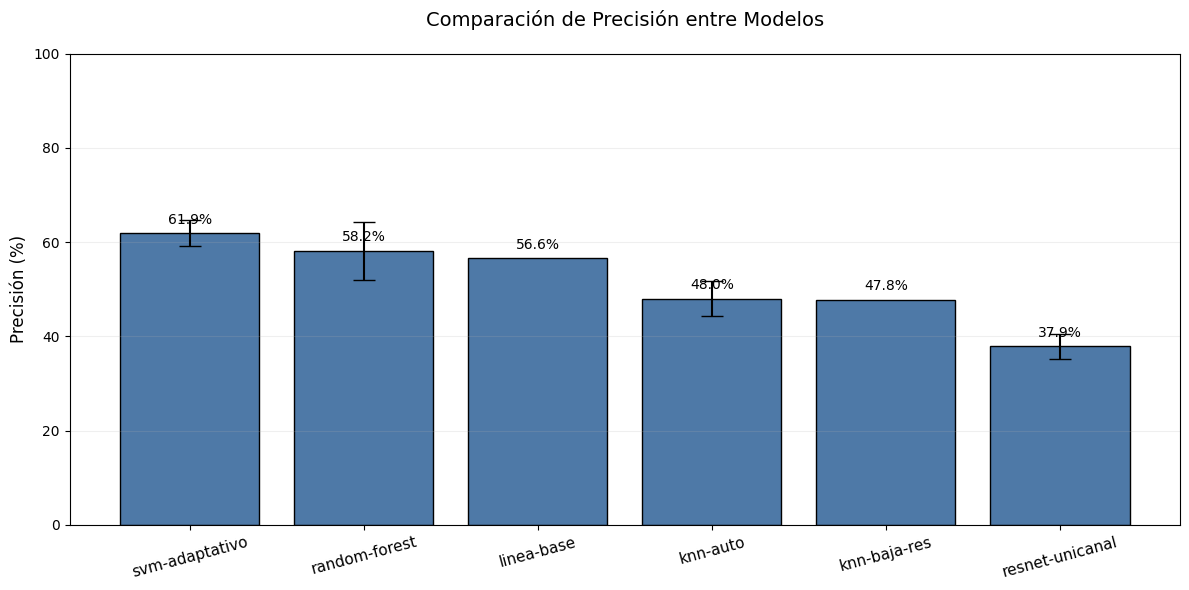

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df['modelo'], df['mean_accuracy']*100, 
        yerr=df['std_accuracy']*100 if 'std_accuracy' in df else 0,
        capsize=8, color='#4e79a7', edgecolor='black')
plt.title('Comparación de Precisión entre Modelos', pad=20, fontsize=14)
plt.ylabel('Precisión (%)', fontsize=12)
plt.xticks(fontsize=11, rotation=15)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.2)

# Añadir valores en las barras
for i, v in enumerate(df['mean_accuracy']):
    plt.text(i, v*100 + 2, f"{v*100:.1f}%", 
             ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('precision_modelos.png', dpi=300)
plt.show()

Donde se observa que el modelo basado en máquinas de vectores soporte obtuvo los valores más altos, seguido del basado en Random Forest. Sin embargo, debe tenerse en cuenta el desbalanceo de clases y el efecto que pueda tener, por lo que se analizan las métricas complementarias robustas a esta causística. También destaca el mal rendimiento del modelo de aprendizaje profundo

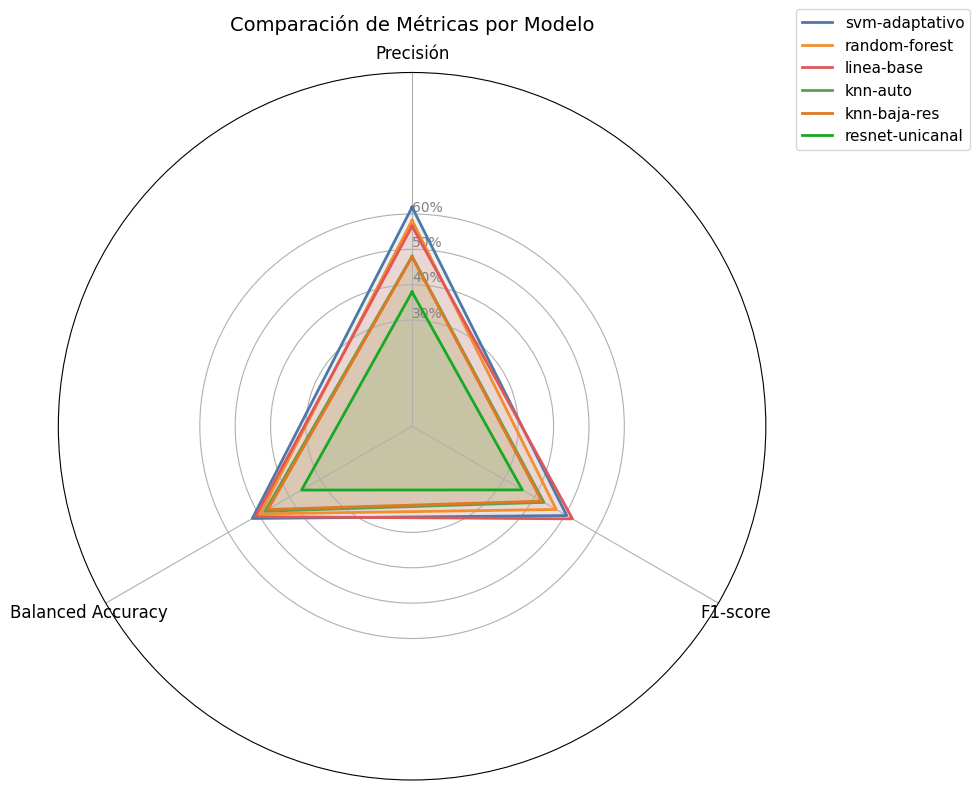

In [20]:
from math import pi

# Preparar datos
categorias = ['mean_accuracy','mean_f1','mean_balanced_accuracy']
N = len(categorias)
angulos = [n / float(N) * 2 * pi for n in range(N)]
angulos += angulos[:1]

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angulos[:-1], ['Precisión', 'F1-score', 'Balanced Accuracy'], fontsize=12)
ax.set_rlabel_position(0)
plt.yticks([0.3, 0.4, 0.5, 0.6], ["30%","40%","50%", "60%"], color="grey", size=10)
plt.ylim(0,1)

# Colores para cada modelo
colores = ['#4e79a7', '#f28e2b', '#e15759', '#59a14f', '#e17924', '#17a924']

for idx, modelo in enumerate(df['modelo']):
    valores = df.loc[modelo, categorias].tolist()
    valores += valores[:1]
    ax.plot(angulos, valores, linewidth=2, linestyle='solid', 
            label=modelo, color=colores[idx])
    ax.fill(angulos, valores, alpha=0.1, color=colores[idx])

plt.title('Comparación de Métricas por Modelo', pad=30, fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.tight_layout()
plt.savefig('radar_metricas.png', dpi=300)
plt.show()

Donde se observa que, a pesar de superar a la línea base en efectividad estándar, los modelos de SVM y Random Forest quedan a su mismo nivel o inferior con respecto a esta.